In [21]:
# Manipulação e Visualização de Dados
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Scikit-Learn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, recall_score, classification_report
from scipy.stats import ks_2samp

import optuna

In [22]:
df_train = pd.read_csv('../data/fold1.csv')
df_val = pd.read_csv('../data/fold2.csv')
df_test = pd.read_csv('../data/fold3.csv')

In [23]:
TARGET = "Churn"

X_train, y_train = df_train.drop(columns=[TARGET]), df_train[TARGET]
X_val,   y_val   = df_val.drop(columns=[TARGET]),   df_val[TARGET]
X_test,  y_test  = df_test.drop(columns=[TARGET]),  df_test[TARGET]

In [24]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)
print("Acurácia Random Forest (validação):", accuracy_score(y_val, rf_preds))

# MLPClassifier
mlp_model = MLPClassifier(random_state=42,max_iter=1500)
mlp_model.fit(X_train, y_train)
mlp_preds = mlp_model.predict(X_val)
print("Acurácia MLP (validação):", accuracy_score(y_val, mlp_preds))

# XGBoost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)
print("Acurácia XGBoost (validação):", accuracy_score(y_val, xgb_preds))

Acurácia Random Forest (validação): 0.7718052738336714
Acurácia MLP (validação): 0.7728194726166329
Acurácia XGBoost (validação): 0.7723123732251521


In [ ]:
def compute_metric(metric, y_true, probs, preds):
    """
    Calcula o score de acordo com a métrica escolhida.
    
    Parâmetros:
      - metric: string ('ks', 'roc', 'accuracy', 'f1', 'recall')
      - y_true: valores reais
      - probs: probabilidades preditas (usadas para KS e ROC-AUC)
      - preds: classes preditas (usadas para acurácia, F1 e recall)
      
    Retorna:
      - Valor da métrica escolhida.
    """
    if metric == 'ks':
        return ks_2samp(probs[y_true == 1], probs[y_true == 0]).statistic
    elif metric == 'roc':
        fpr, tpr, thresholds = roc_curve(y_true, probs)
        return auc(fpr, tpr)
    elif metric == 'accuracy':
        return accuracy_score(y_true, preds)
    elif metric == 'f1':
        return f1_score(y_true, preds)
    elif metric == 'recall':
        return recall_score(y_true, preds)
    else:
        raise ValueError("Métrica não suportada. Escolha entre 'ks', 'roc', 'accuracy', 'f1' ou 'recall'.")
    
PARAM_SPACE = {
    "rf": {
        "n_estimators":           (50, 300,    "int"),
        "max_depth":              (2, 80,     "int_log"),
        "min_samples_split":      (2, 20,     "int"),
        "min_samples_leaf":       (1, 20,     "int"),
        "max_features":           (0.1, 1.0,  "float"),
        "bootstrap":              [True, False],
        "criterion":              ["gini", "entropy"],
    },
    "mlp": {
        "hidden_layer_sizes":     [(50,), (100,), (50, 50), (100, 50), (100, 100)],
        "activation":             ["relu", "tanh", "logistic"],
        "solver":                 ["adam", "sgd"],
        "alpha":                  (1e-5, 1e-2,    "float_log"),
        "learning_rate_init":     (1e-7, 1e-1,    "float_log"),
        "batch_size":             ["auto", 8, 16, 32, 64, 128],
        "max_iter":               [ 500, 1000,1300,1500,2000],
        "momentum":               (0.0, 0.99,     "float"),
        "learning_rate":          ["constant", "invscaling", "adaptive"],
        "tol":                    (1e-5, 1e-2,    "float_log"),
    },
    "xgb": {
        "n_estimators":           (50, 300,    "int"),
        "max_depth":              (2, 10,     "int_log"),
        "learning_rate":          (1e-3, 0.3,  "float_log"),
        "gamma":                  (0, 5,       "float"),
        "subsample":              (0.5, 1.0,   "float"),
        "colsample_bytree":       (0.5, 1.0,   "float"),
        "reg_alpha":              (1e-5, 1e-1, "float_log"),
        "reg_lambda":             (1e-5, 1e-1, "float_log"),
    }
}


def get_objective(model_name, metric="ks"):
    space = PARAM_SPACE[model_name]
    def objective(trial):
        # sugere tudo dinamicamente
        kwargs = {}
        for k,v in space.items():
            if isinstance(v, tuple):
                low, high, kind = v
                if kind=="int":
                    kwargs[k] = trial.suggest_int(k, low, high)
                elif kind=="int_log":
                    kwargs[k] = trial.suggest_int(k, low, high, log=True)
                elif kind=="float":
                    kwargs[k] = trial.suggest_float(k, low, high)
                elif kind=="float_log":
                    kwargs[k] = trial.suggest_float(k, low, high, log=True)
            else:
                # lista de choices
                kwargs[k] = trial.suggest_categorical(k, v)

        # instancia o modelo
        if model_name=="rf":
            clf = RandomForestClassifier(random_state=42, **kwargs)
        elif model_name=="mlp":
            clf = MLPClassifier(random_state=42, **kwargs)
        else:  # xgb
            clf = XGBClassifier(random_state=42, use_label_encoder=False,
                                eval_metric="logloss", **kwargs)
        # fit & score
        clf.fit(X_train, y_train)
        probs = clf.predict_proba(X_val)[:,1]
        preds = clf.predict(X_val)
        return compute_metric(metric, y_val, probs, preds)
    return objective

for model in ["rf","mlp","xgb"]:
    study = optuna.create_study(direction="maximize")
    study.optimize(get_objective(model), n_trials=50)
    print(model, "→ :best_params:", study.best_params, "| best_score:", study.best_value)
    if model == "rf":
        best_rf_params = study.best_params
    elif model == "mlp":
        best_mlp_params = study.best_params
    elif model == "xgb":
        best_xgb_params = study.best_params


[I 2025-04-28 09:35:32,621] A new study created in memory with name: no-name-7a422d4b-da96-4e0e-a9a9-47f282c07427
[I 2025-04-28 09:35:33,189] Trial 0 finished with value: 0.5447232679754086 and parameters: {'n_estimators': 225, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 19, 'max_features': 0.13521972704874113, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5447232679754086.
[I 2025-04-28 09:35:35,540] Trial 1 finished with value: 0.5318826064523962 and parameters: {'n_estimators': 199, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 0.9718632531922036, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5447232679754086.
[I 2025-04-28 09:35:35,777] Trial 2 finished with value: 0.5578265224121073 and parameters: {'n_estimators': 103, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.17206239446235078, 'bootstrap': True, 'criterion': 'gini'}. Best is trial 2

rf → :best_params: {'n_estimators': 103, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.17206239446235078, 'bootstrap': True, 'criterion': 'gini'} | best_score: 0.5578265224121073


[I 2025-04-28 09:36:03,797] Trial 0 finished with value: 0.054005729539855406 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'logistic', 'solver': 'sgd', 'alpha': 3.8476258475435895e-05, 'learning_rate_init': 2.020567616372743e-07, 'batch_size': 16, 'max_iter': 2000, 'momentum': 0.44654650034478854, 'learning_rate': 'adaptive', 'tol': 0.0005766021472445699}. Best is trial 0 with value: 0.054005729539855406.
c:\Users\hyggo\anaconda3\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
c:\Users\hyggo\anaconda3\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
c:\Users\hyggo\anaconda3\lib\site-pac

mlp → :best_params: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0016895298257933523, 'learning_rate_init': 0.00017397412202110025, 'batch_size': 64, 'max_iter': 1300, 'momentum': 0.3471722454010656, 'learning_rate': 'invscaling', 'tol': 0.00013432984731195569} | best_score: 0.5544088558470469


[I 2025-04-28 09:48:03,935] Trial 0 finished with value: 0.5314524291164079 and parameters: {'n_estimators': 231, 'max_depth': 8, 'learning_rate': 0.006314373333184244, 'gamma': 0.8066897164626241, 'subsample': 0.5866600215943433, 'colsample_bytree': 0.7639108391394857, 'reg_alpha': 0.0180338497740867, 'reg_lambda': 0.0013448164601851016}. Best is trial 0 with value: 0.5314524291164079.
c:\Users\hyggo\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-04-28 09:48:04,877] Trial 1 finished with value: 0.542440425057434 and parameters: {'n_estimators': 262, 'max_depth': 6, 'learning_rate': 0.02472481147372668, 'gamma': 4.54364057921951, 'subsample': 0.5192467768716817, 'colsample_bytree': 0.7993460703145702, 'reg_alpha': 0.0007251570884307693, 'reg_lambda': 0.00040209017605141126}. Best is trial 1 with value: 0.542440425057434.
c:\Users\hyggo\anaconda3\lib\site

xgb → :best_params: {'n_estimators': 181, 'max_depth': 2, 'learning_rate': 0.034086900335549314, 'gamma': 1.6478134039856276, 'subsample': 0.6339990719450903, 'colsample_bytree': 0.6094061736031922, 'reg_alpha': 0.004519046789752244, 'reg_lambda': 0.0011747913628717445} | best_score: 0.5604286994261223


In [ ]:
# best_rf_params = {'n_estimators': 132, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.22290137215315986, 'bootstrap': True, 'criterion': 'entropy'}
# best_mlp_params = {'hidden_layer_sizes': (100, 50), 'activation': 'tanh', 'solver': 'adam', 'alpha': 9.378890046495715e-05, 'learning_rate_init': 9.351095668258579e-06, 'batch_size': 16, 'max_iter': 1500, 'momentum': 0.7731362527089873, 'learning_rate': 'invscaling', 'tol': 4.0359613960011186e-05}
# best_xgb_params = {'n_estimators': 181,
#  'max_depth': 2,
#  'learning_rate': 0.034086900335549314,
#  'gamma': 1.6478134039856276,
#  'subsample': 0.6339990719450903,
#  'colsample_bytree': 0.6094061736031922,
#  'reg_alpha': 0.004519046789752244,
#  'reg_lambda': 0.0011747913628717445}

In [27]:
from matplotlib import pyplot as plt


def plot_ks(probabilities, y_true, model_name):
    """
    Plota a curva KS para um modelo.
    
    Parâmetros:
    - probabilities: array com as probabilidades preditas para a classe positiva.
    - y_true: array/Series com os rótulos reais.
    - model_name: nome do modelo (string) para identificação no gráfico.
    """
    # Separar probabilidades para as classes 1 (positiva) e 0 (negativa)
    pos_probs = probabilities[y_true == 1]
    neg_probs = probabilities[y_true == 0]
    
    # Definir os thresholds (pontos de corte) como os valores únicos preditos
    thresholds = np.sort(np.unique(np.concatenate((pos_probs, neg_probs))))
    
    # Calcular as CDFs empíricas para cada grupo
    pos_cdf = [np.mean(pos_probs <= t) for t in thresholds]
    neg_cdf = [np.mean(neg_probs <= t) for t in thresholds]
    
    # Calcular a diferença absoluta entre as duas CDFs e identificar o máximo
    differences = np.abs(np.array(pos_cdf) - np.array(neg_cdf))
    ks_stat = np.max(differences)
    ks_index = np.argmax(differences)
    ks_threshold = thresholds[ks_index]
    
    # Plotar as CDFs
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, pos_cdf, label=f'{model_name} - Classe 1 (Positivo)')
    plt.plot(thresholds, neg_cdf, label=f'{model_name} - Classe 0 (Negativo)')
    plt.axvline(x=ks_threshold, color='red', linestyle='--', 
                label=f'KS = {ks_stat:.2f} (limiar = {ks_threshold:.2f})')
    plt.xlabel('Probabilidade predita')
    plt.ylabel('CDF')
    plt.title(f'Curva KS para {model_name}')
    plt.legend(loc='best')
    plt.show()

c:\Users\hyggo\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



=== Fold 1 ===
Random Forest | AUC = 0.8399


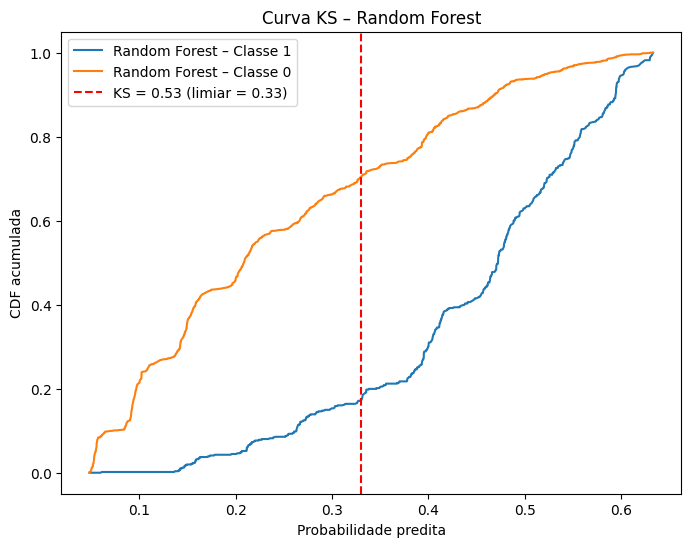

MLP | AUC = 0.8444


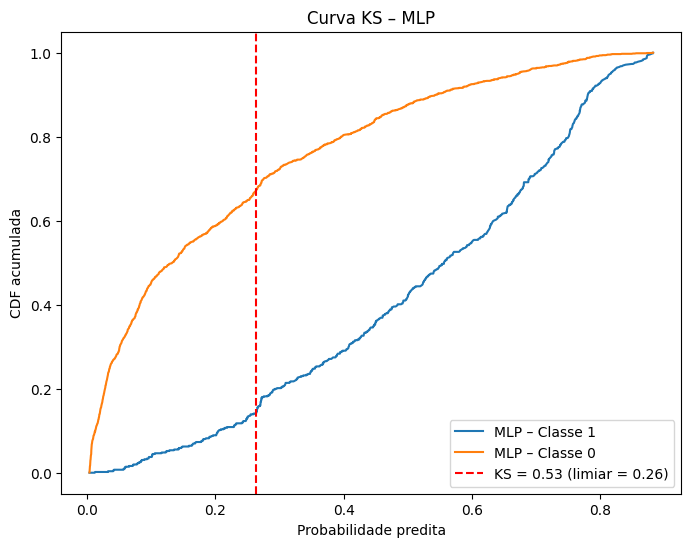

XGBoost | AUC = 0.8490


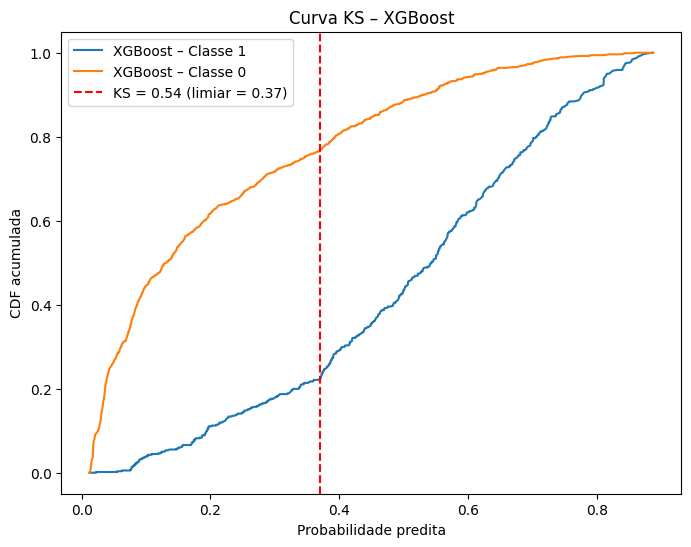

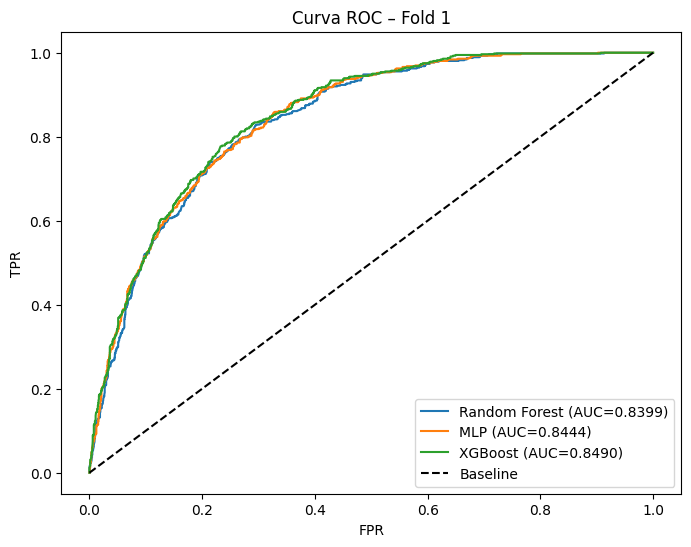

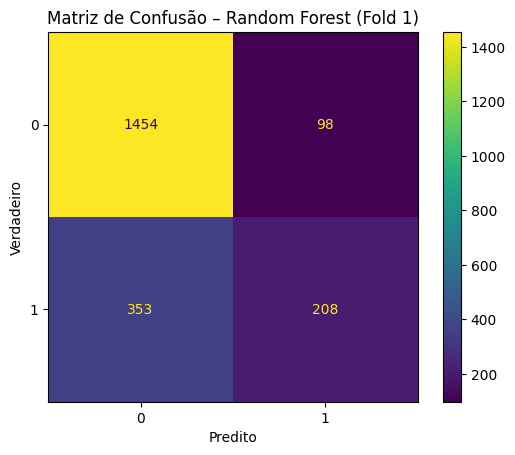

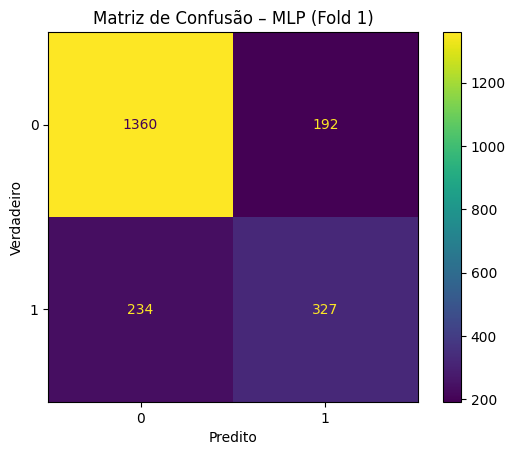

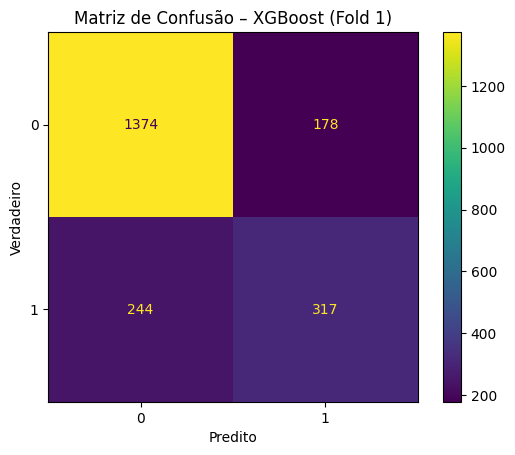


=== Fold 2 ===
Random Forest | AUC = 0.8374


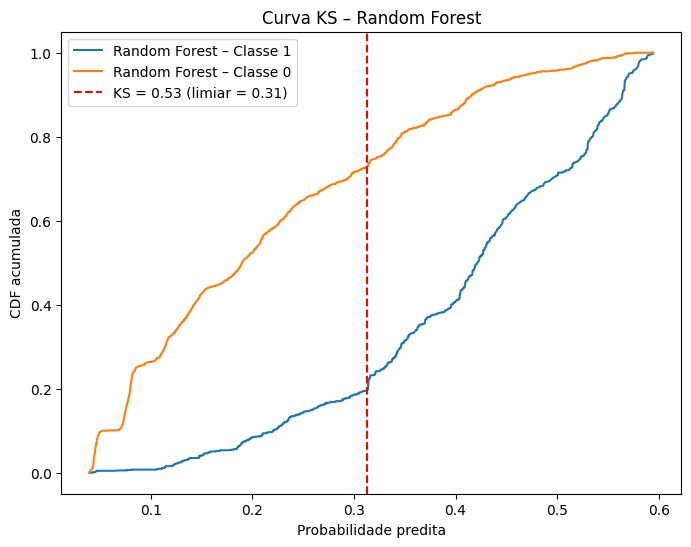

MLP | AUC = 0.8419


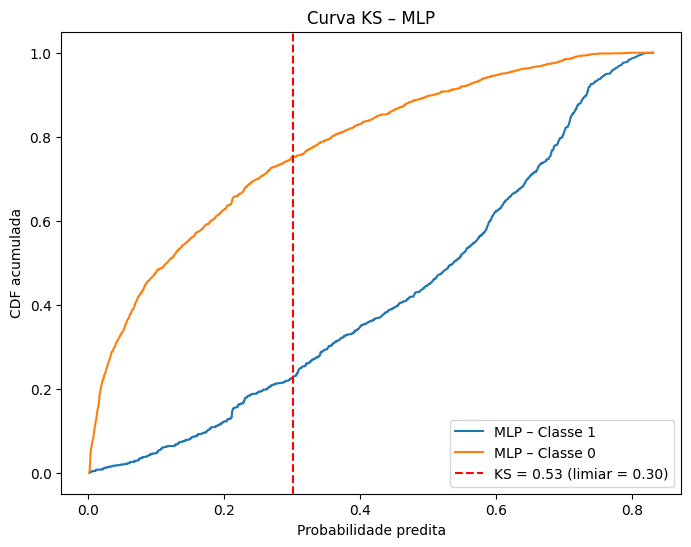

XGBoost | AUC = 0.8434


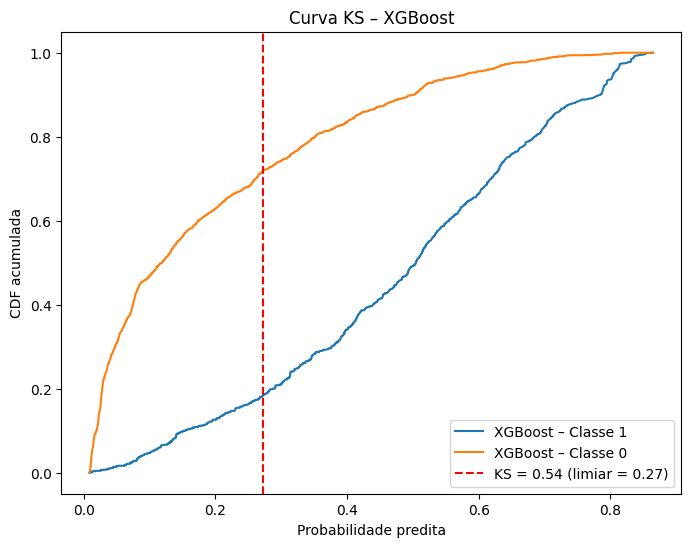

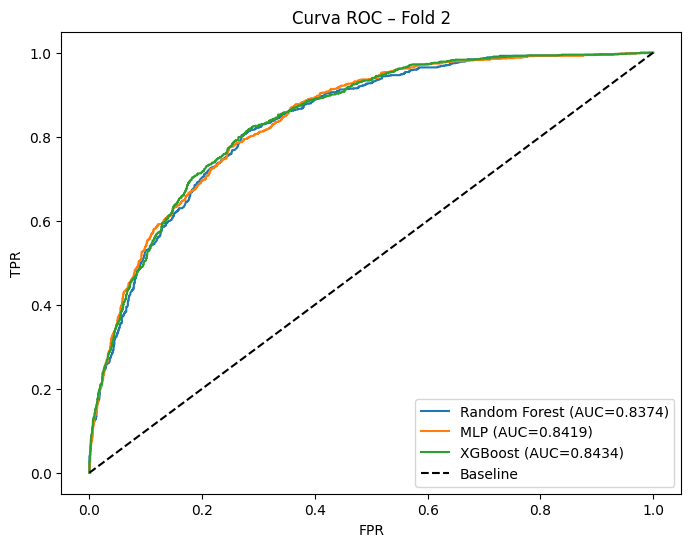

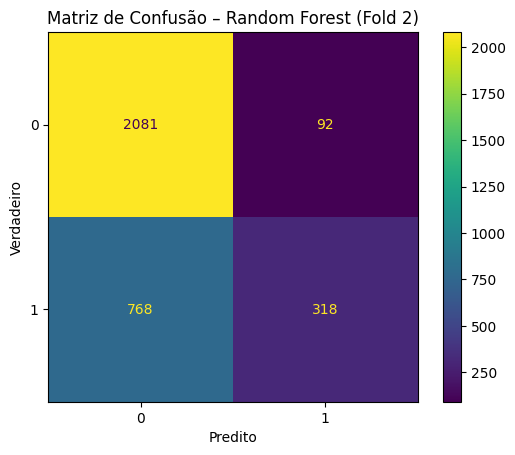

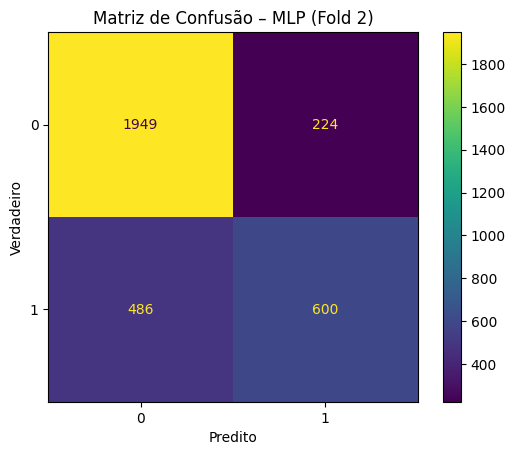

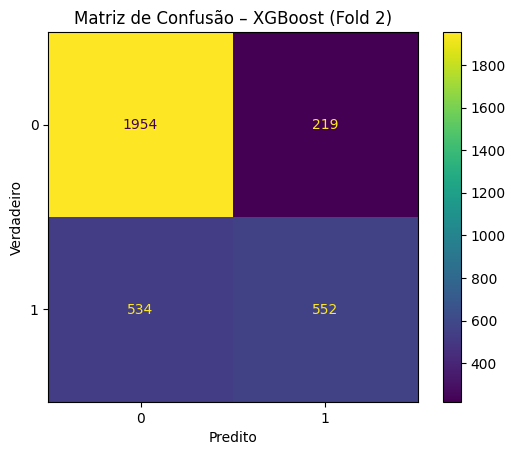


=== Fold 3 ===
Random Forest | AUC = 0.8407


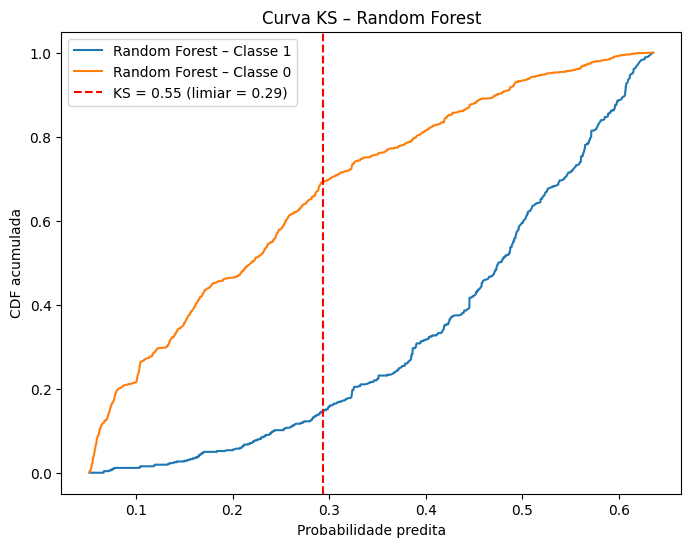

MLP | AUC = 0.8458


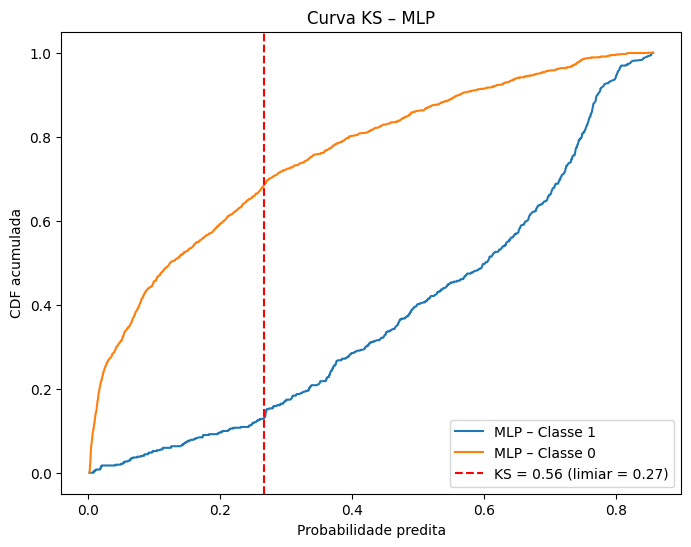

XGBoost | AUC = 0.8485


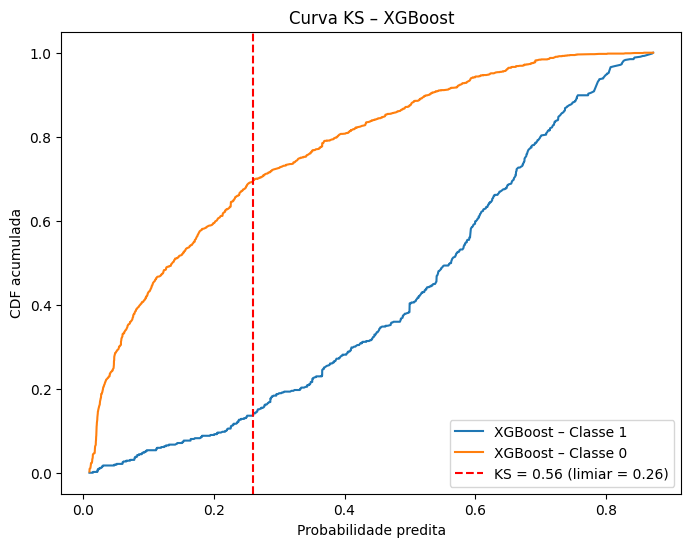

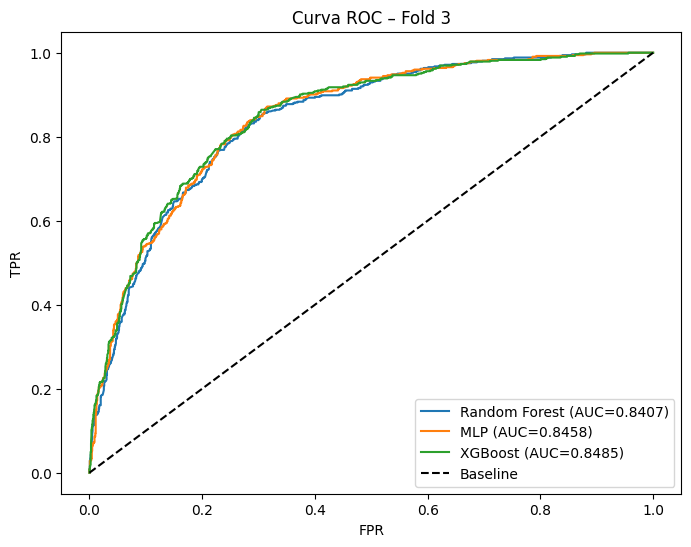

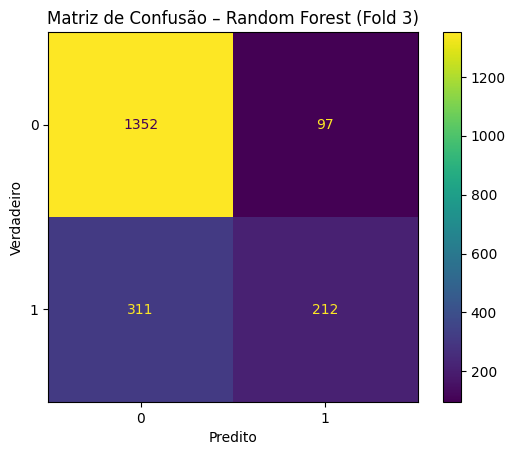

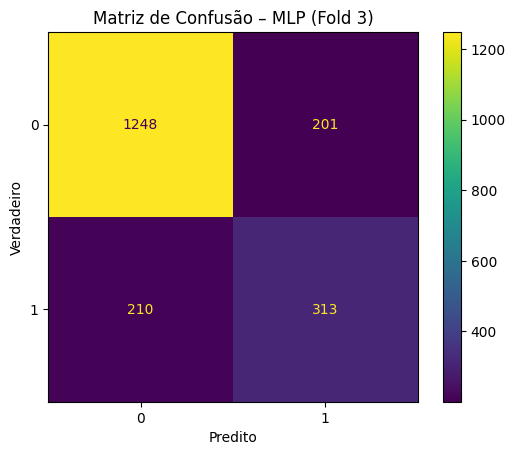

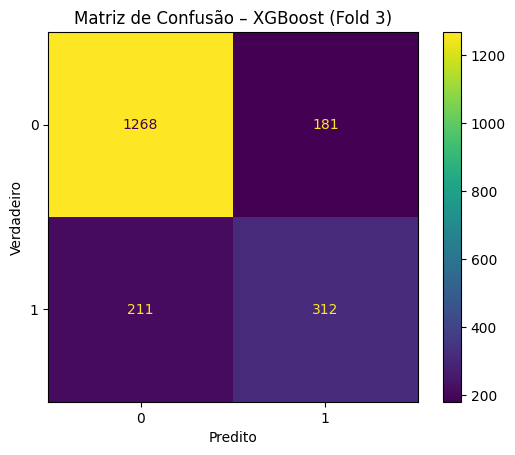

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Função para plotar a curva KS de um modelo
def plot_ks(probabilities, y_true, model_name):
    """
    Plota a curva KS para um modelo.
    
    Parâmetros:
    - probabilities: array com as probabilidades preditas para a classe positiva.
    - y_true: array/Series com os rótulos reais (1D).
    - model_name: nome do modelo (string) para identificação no gráfico.
    """
    pos_probs = probabilities[y_true == 1]
    neg_probs = probabilities[y_true == 0]
    
    thresholds = np.sort(np.unique(np.concatenate((pos_probs, neg_probs))))
    pos_cdf = [np.mean(pos_probs <= t) for t in thresholds]
    neg_cdf = [np.mean(neg_probs <= t) for t in thresholds]
    
    differences = np.abs(np.array(pos_cdf) - np.array(neg_cdf))
    ks_stat    = np.max(differences)
    ks_idx     = np.argmax(differences)
    ks_thresh  = thresholds[ks_idx]
    
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, pos_cdf, label=f'{model_name} – Classe 1')
    plt.plot(thresholds, neg_cdf, label=f'{model_name} – Classe 0')
    plt.axvline(x=ks_thresh, color='red', linestyle='--',
                label=f'KS = {ks_stat:.2f} (limiar = {ks_thresh:.2f})')
    plt.xlabel('Probabilidade predita')
    plt.ylabel('CDF acumulada')
    plt.title(f'Curva KS – {model_name}')
    plt.legend(loc='best')
    plt.show()

# --- 1) Transformar seus dados em DataFrames (se ainda não estiverem) ---
X_train_df = pd.DataFrame(X_train)
X_valid_df = pd.DataFrame(X_val)
X_test_df  = pd.DataFrame(X_test)

y_train_df = pd.DataFrame(y_train)
y_valid_df = pd.DataFrame(y_val)
y_test_df  = pd.DataFrame(y_test)

# --- 2) Definir modelos com parâmetros ajustados ---
models = {
    "Random Forest": RandomForestClassifier(random_state=42, **best_rf_params),
    "MLP":           MLPClassifier(random_state=42, **best_mlp_params),
    "XGBoost":       XGBClassifier(
                         random_state=42,
                         use_label_encoder=False,
                         eval_metric='logloss',
                         **best_xgb_params
                     )
}

# --- 3) Construir os 3 folds conforme solicitado ---
folds = [
    {
        "X_train": pd.concat([X_train_df, X_valid_df], axis=0).reset_index(drop=True),
        "y_train": pd.concat([y_train_df, y_valid_df], axis=0).reset_index(drop=True),
        "X_test":  X_test_df.reset_index(drop=True),
        "y_test":  y_test_df.reset_index(drop=True)
    },
    {
        "X_train": pd.concat([X_valid_df, X_test_df], axis=0).reset_index(drop=True),
        "y_train": pd.concat([y_valid_df, y_test_df], axis=0).reset_index(drop=True),
        "X_test":  X_train_df.reset_index(drop=True),
        "y_test":  y_train_df.reset_index(drop=True)
    },
    {
        "X_train": pd.concat([X_test_df, X_train_df], axis=0).reset_index(drop=True),
        "y_train": pd.concat([y_test_df, y_train_df], axis=0).reset_index(drop=True),
        "X_test":  X_valid_df.reset_index(drop=True),
        "y_test":  y_valid_df.reset_index(drop=True)
    }
]

# --- 4) Loop por fold treinando, avaliando e plotando ---
for i, fold in enumerate(folds, start=1):
    # Extrai e achata y para vetor 1D
    X_tr = fold["X_train"]
    y_tr = fold["y_train"].squeeze().values.ravel()
    X_te = fold["X_test"]
    y_te = fold["y_test"].squeeze().values.ravel()

    roc_data = {}
    cm_data  = {}

    print(f"\n=== Fold {i} ===")
    for name, model in models.items():
        # Treina
        model.fit(X_tr, y_tr)

        # Predição e probabilidade
        y_pred  = model.predict(X_te)
        y_proba = model.predict_proba(X_te)[:, 1]

        # ROC & AUC
        fpr, tpr, _ = roc_curve(y_te, y_proba, pos_label=1)
        roc_auc = auc(fpr, tpr)
        roc_data[name] = (fpr, tpr, roc_auc)

        # Imprime AUC
        print(f"{name} | AUC = {roc_auc:.4f}")

        # Plota KS usando a função definida
        plot_ks(y_proba, y_te, name)

        # Matriz de Confusão
        cm = confusion_matrix(y_te, y_pred, labels=[0,1])
        cm_data[name] = cm

    # 4a) Plot agregado de ROC deste fold
    plt.figure(figsize=(8,6))
    for name, (fpr, tpr, auc_) in roc_data.items():
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_:.4f})")
    plt.plot([0,1], [0,1], 'k--', label="Baseline")
    plt.title(f"Curva ROC – Fold {i}")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend(loc="lower right")
    plt.show()

    # 4b) Matrizes de Confusão deste fold
    for name, cm in cm_data.items():
        fig, ax = plt.subplots()
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
        disp.plot(ax=ax)
        ax.set_title(f"Matriz de Confusão – {name} (Fold {i})")
        plt.xlabel("Predito"); plt.ylabel("Verdadeiro")
        plt.show()


c:\Users\hyggo\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



=== Fold 1 ===
Random Forest | AUC = 0.8399 | KS = 0.5326
MLP | AUC = 0.8444 | KS = 0.5307
XGBoost | AUC = 0.8490 | KS = 0.5446


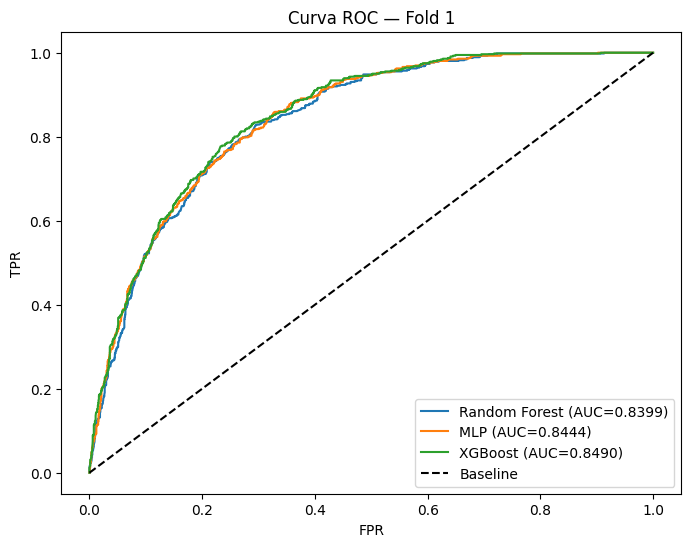


KS Statistic deste fold:
  Random Forest: 0.5326
  MLP: 0.5307
  XGBoost: 0.5446


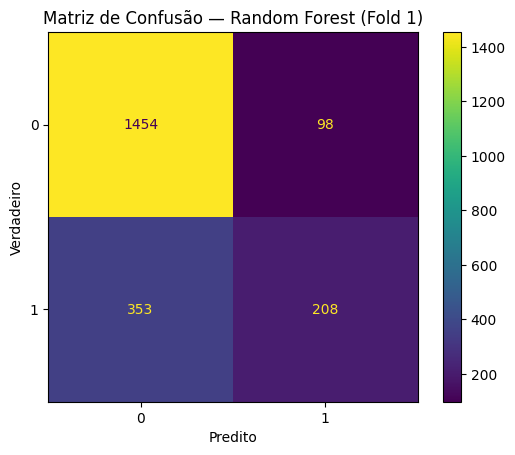

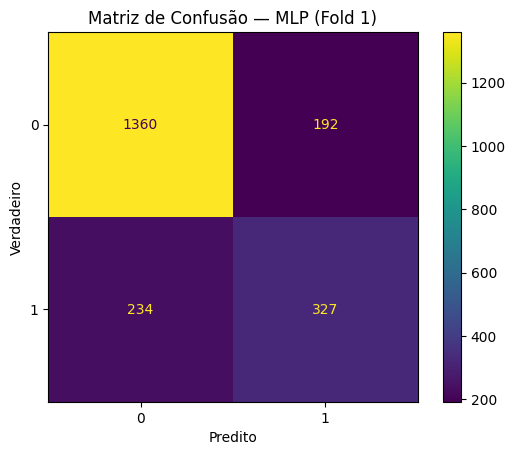

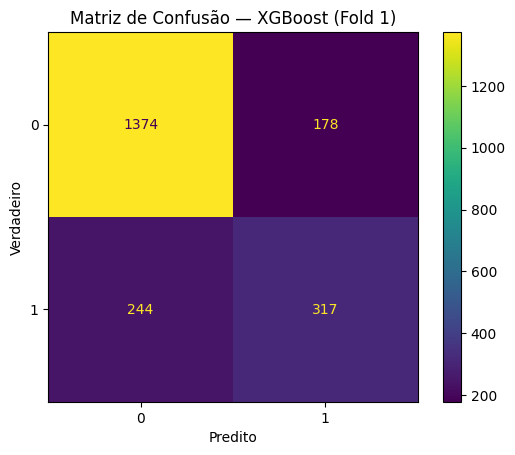


=== Fold 2 ===
Random Forest | AUC = 0.8374 | KS = 0.5337
MLP | AUC = 0.8419 | KS = 0.5268
XGBoost | AUC = 0.8434 | KS = 0.5356


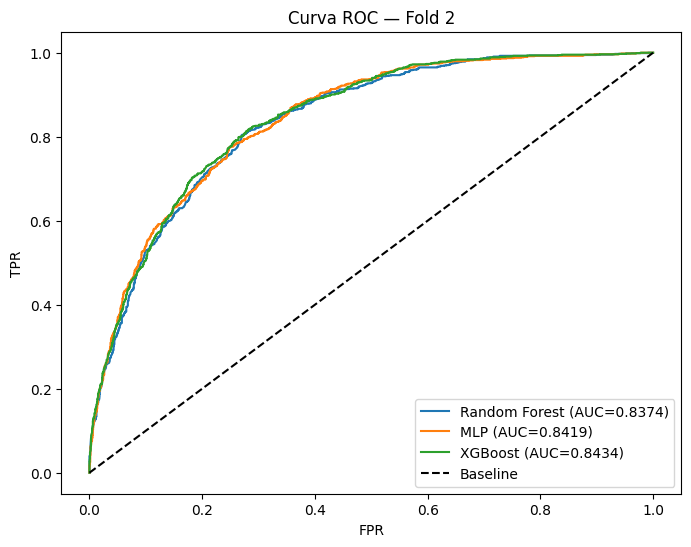


KS Statistic deste fold:
  Random Forest: 0.5337
  MLP: 0.5268
  XGBoost: 0.5356


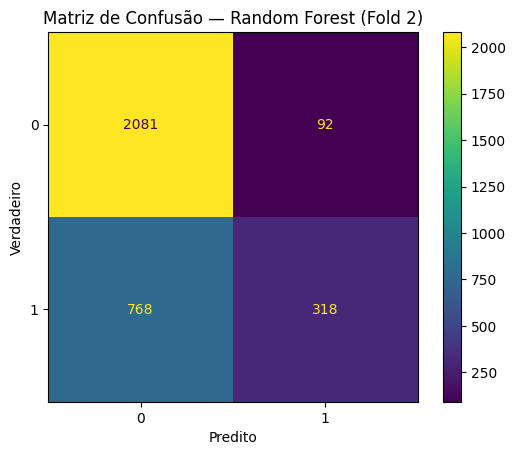

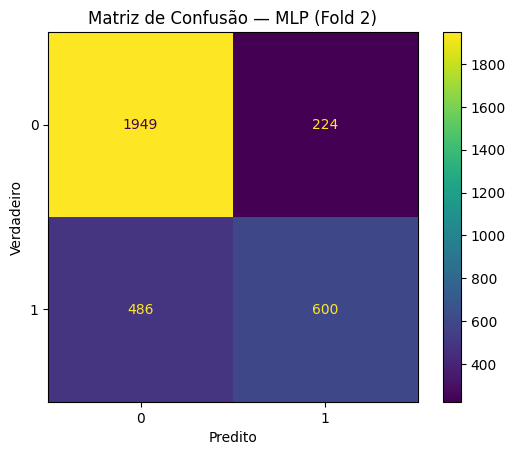

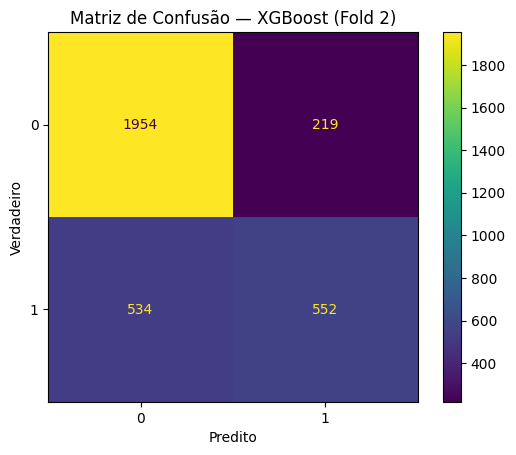


=== Fold 3 ===
Random Forest | AUC = 0.8407 | KS = 0.5469
MLP | AUC = 0.8458 | KS = 0.5565
XGBoost | AUC = 0.8485 | KS = 0.5592


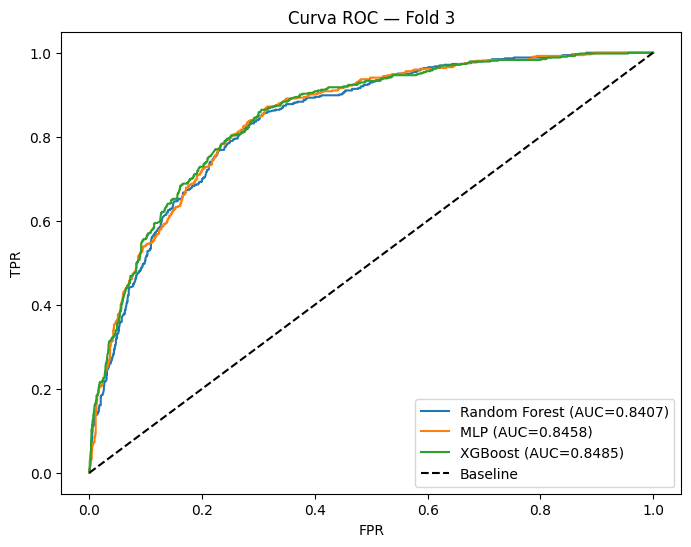


KS Statistic deste fold:
  Random Forest: 0.5469
  MLP: 0.5565
  XGBoost: 0.5592


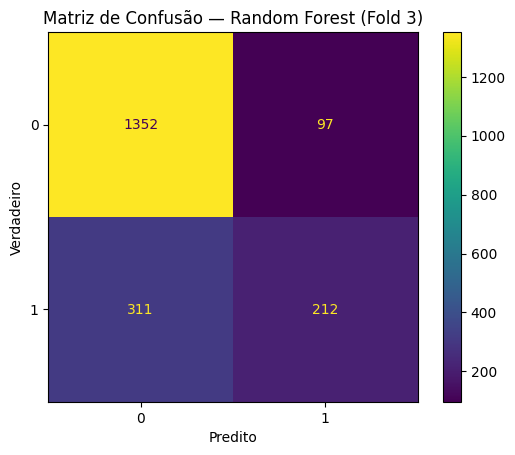

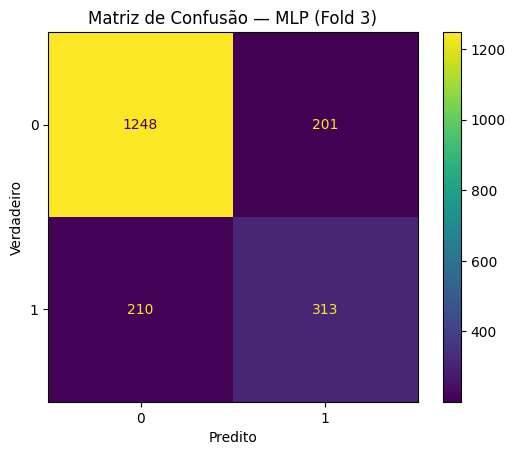

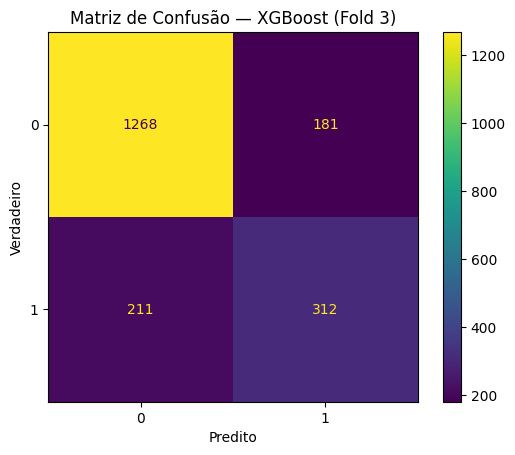

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# --- 1) Dados pré-existentes ---
# X_train, X_val, X_test, y_train, y_val, y_test já estão definidos no seu script

# Transforma em DataFrames (se ainda não estiverem)
X_train_df = pd.DataFrame(X_train)
X_valid_df = pd.DataFrame(X_val)
X_test_df  = pd.DataFrame(X_test)

y_train_df = pd.DataFrame(y_train)
y_valid_df = pd.DataFrame(y_val)
y_test_df  = pd.DataFrame(y_test)

# --- 2) Modelos com hiperparâmetros otimizados ---
models = {
    "Random Forest": RandomForestClassifier(random_state=42, **best_rf_params),
    "MLP":           MLPClassifier(random_state=42, **best_mlp_params),
    "XGBoost":       XGBClassifier(
                         random_state=42,
                         use_label_encoder=False,
                         eval_metric='logloss',
                         **best_xgb_params
                     )
}

# --- 3) Definição dos 3 folds conforme desejado ---
folds = [
    # Fold 1: treino = train + valid ; teste = test
    {
        "X_train": pd.concat([X_train_df, X_valid_df], axis=0).reset_index(drop=True),
        "y_train": pd.concat([y_train_df, y_valid_df], axis=0).reset_index(drop=True),
        "X_test":  X_test_df.reset_index(drop=True),
        "y_test":  y_test_df.reset_index(drop=True)
    },
    # Fold 2: treino = valid + test ; teste = train
    {
        "X_train": pd.concat([X_valid_df, X_test_df], axis=0).reset_index(drop=True),
        "y_train": pd.concat([y_valid_df, y_test_df], axis=0).reset_index(drop=True),
        "X_test":  X_train_df.reset_index(drop=True),
        "y_test":  y_train_df.reset_index(drop=True)
    },
    # Fold 3: treino = test + train ; teste = valid
    {
        "X_train": pd.concat([X_test_df, X_train_df], axis=0).reset_index(drop=True),
        "y_train": pd.concat([y_test_df, y_train_df], axis=0).reset_index(drop=True),
        "X_test":  X_valid_df.reset_index(drop=True),
        "y_test":  y_valid_df.reset_index(drop=True)
    }
]

# --- 4) Loop sobre cada fold, treinando e plotando ---
for i, fold in enumerate(folds, start=1):
    # Extrai X e y; garante que y seja vetor 1D
    X_tr = fold["X_train"]
    y_tr = fold["y_train"].squeeze().values.ravel()
    X_te = fold["X_test"]
    y_te = fold["y_test"].squeeze().values.ravel()

    # Containers para resultados deste fold
    roc_data = {}   # { modelo: (fpr, tpr, auc) }
    ks_data  = {}   # { modelo: ks_stat }
    cm_data  = {}   # { modelo: conf_matrix }

    print(f"\n=== Fold {i} ===")
    for name, model in models.items():
        # Treina
        model.fit(X_tr, y_tr)

        # Predições
        y_pred  = model.predict(X_te)
        y_proba = model.predict_proba(X_te)[:, 1]

        # ROC & AUC
        fpr, tpr, _ = roc_curve(y_te, y_proba, pos_label=1)
        roc_auc = auc(fpr, tpr)
        roc_data[name] = (fpr, tpr, roc_auc)

        # KS Statistic
        ks_stat = ks_2samp(
            y_proba[y_te == 1],
            y_proba[y_te == 0]
        ).statistic
        ks_data[name] = ks_stat

        # Confusion Matrix
        cm = confusion_matrix(y_te, y_pred, labels=[0,1])
        cm_data[name] = cm

        print(f"{name} | AUC = {roc_auc:.4f} | KS = {ks_stat:.4f}")

    # 4a) Plot ROC deste fold
    plt.figure(figsize=(8,6))
    for name, (fpr, tpr, auc_) in roc_data.items():
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_:.4f})")
    plt.plot([0,1], [0,1], 'k--', label="Baseline")
    plt.title(f"Curva ROC — Fold {i}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend(loc="lower right")
    plt.show()

    # 4b) Exibe valores de KS deste fold em vez de plotar gráfico de barras
    print("\nKS Statistic deste fold:")
    for name, ks_val in ks_data.items():
        print(f"  {name}: {ks_val:.4f}")

    # 4c) Matrizes de Confusão deste fold
    for name, cm in cm_data.items():
        fig, ax = plt.subplots()
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
        disp.plot(ax=ax)
        ax.set_title(f"Matriz de Confusão — {name} (Fold {i})")
        plt.xlabel("Predito")
        plt.ylabel("Verdadeiro")
        plt.show()


C:\Users\hyggo\AppData\Local\Temp\ipykernel_15848\1800886670.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  final_rf_model.fit(X_train_final, y_train_final)


Final Random Forest Test Accuracy: 0.7865593942262187


c:\Users\hyggo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Final MLP Test Accuracy: 0.7983909133932797


c:\Users\hyggo\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Final XGBoost Test Accuracy: 0.8002839564600095


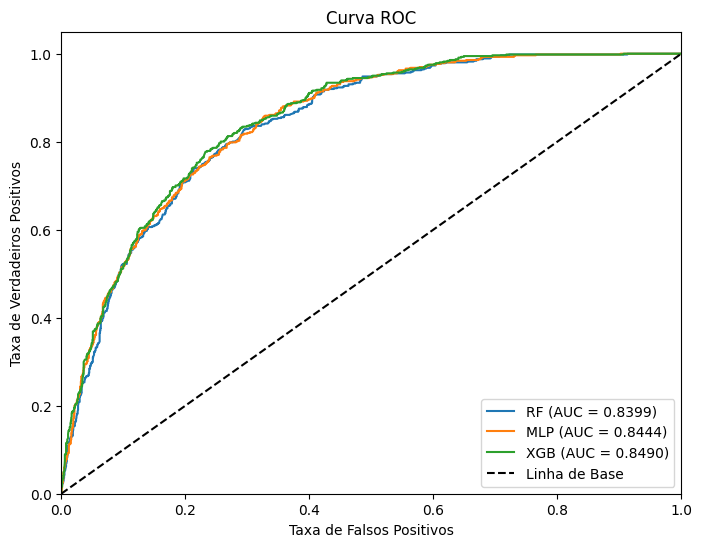

KS Statistic Random Forest: 0.5326357112666997
KS Statistic MLP: 0.5307222467243692
KS Statistic XGBoost: 0.5445805079295073


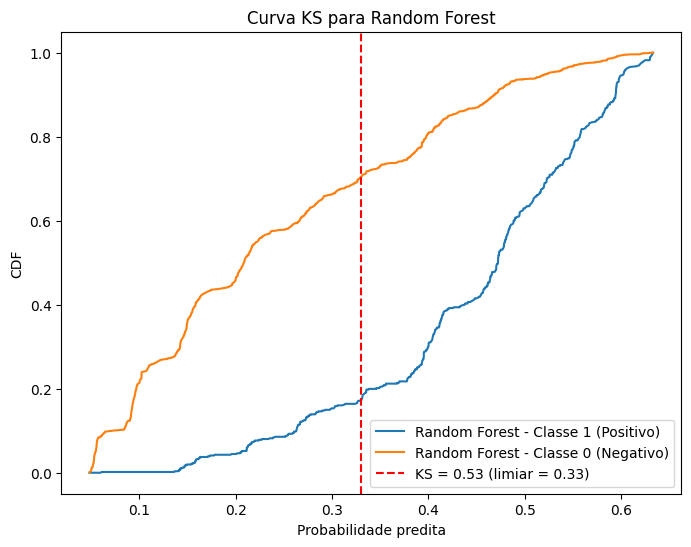

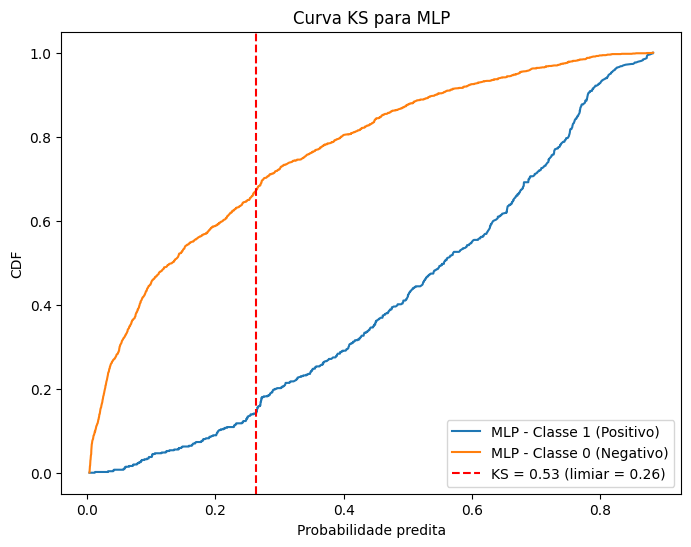

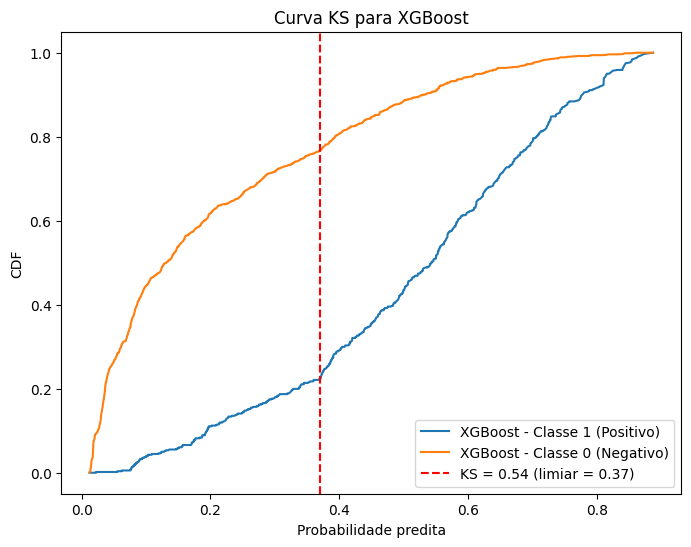

In [28]:
# Combinar os conjuntos de treino e validação para treinar o modelo final
X_train_df = pd.DataFrame(X_train)
X_valid_df = pd.DataFrame(X_val)
X_train_final = pd.concat([X_train_df, X_valid_df], axis=0)

y_train_df = pd.DataFrame(y_train)
y_valid_df = pd.DataFrame(y_val)
y_train_final = pd.concat([y_train_df, y_valid_df], axis=0)

# --- Modelo Final: Random Forest ---
final_rf_model = RandomForestClassifier(random_state=42, **best_rf_params)
final_rf_model.fit(X_train_final, y_train_final)
rf_test_preds = final_rf_model.predict(X_test)
rf_test_accuracy = accuracy_score(y_test, rf_test_preds)
print("Final Random Forest Test Accuracy:", rf_test_accuracy)

# --- Modelo Final: MLPClassifier ---
final_mlp_model = MLPClassifier(random_state=42, **best_mlp_params)
final_mlp_model.fit(X_train_final, y_train_final)
mlp_test_preds = final_mlp_model.predict(X_test)
mlp_test_accuracy = accuracy_score(y_test, mlp_test_preds)
print("Final MLP Test Accuracy:", mlp_test_accuracy)

# --- Modelo Final: XGBoost ---
final_xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **best_xgb_params)
final_xgb_model.fit(X_train_final, y_train_final)
xgb_test_preds = final_xgb_model.predict(X_test)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_preds)
print("Final XGBoost Test Accuracy:", xgb_test_accuracy)
# Para métricas baseadas em probabilidades, obtemos as probabilidades da classe positiva:
xgb_probs = final_xgb_model.predict_proba(X_test)[:, 1]

# --- Avaliação com Curva ROC e KS Statistic ---
# Obter probabilidades preditas para a classe positiva ("Yes")
rf_probs = final_rf_model.predict_proba(X_test)[:, 1]
mlp_probs = final_mlp_model.predict_proba(X_test)[:, 1]
# (xgb_probs já foi obtido acima)

# Curva ROC para Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs, pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)
# Curva ROC para MLP
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_probs, pos_label=1)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
# Curva ROC para XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs, pos_label=1)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plotar as curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {roc_auc_rf:.4f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {roc_auc_mlp:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Linha de Base')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Cálculo do KS Statistic (comparando as probabilidades entre 1 e 0)
ks_rf = ks_2samp(rf_probs[y_test == 1], rf_probs[y_test == 0]).statistic
ks_mlp = ks_2samp(mlp_probs[y_test == 1], mlp_probs[y_test == 0]).statistic
ks_xgb = ks_2samp(xgb_probs[y_test == 1], xgb_probs[y_test == 0]).statistic

print("KS Statistic Random Forest:", ks_rf)
print("KS Statistic MLP:", ks_mlp)
print("KS Statistic XGBoost:", ks_xgb)

plot_ks(rf_probs, y_test, 'Random Forest')
plot_ks(mlp_probs, y_test, 'MLP')
plot_ks(xgb_probs, y_test, 'XGBoost')

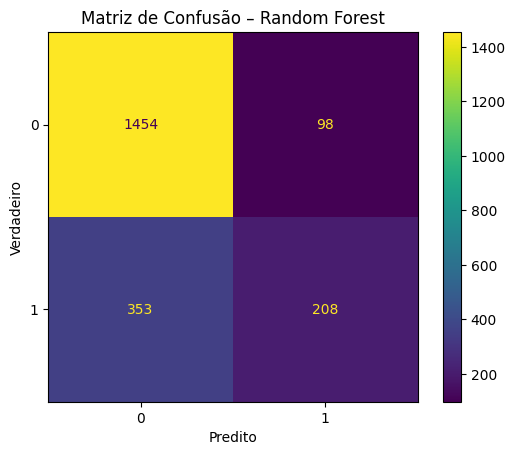

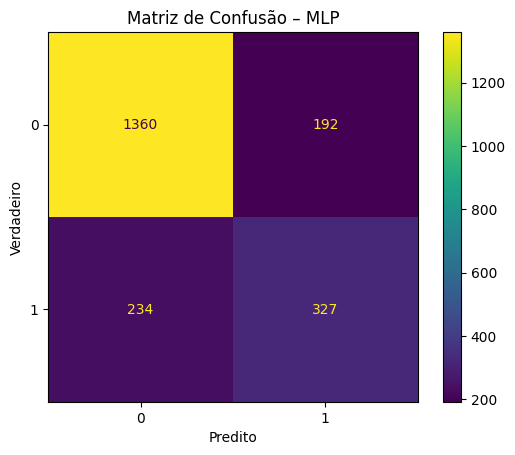

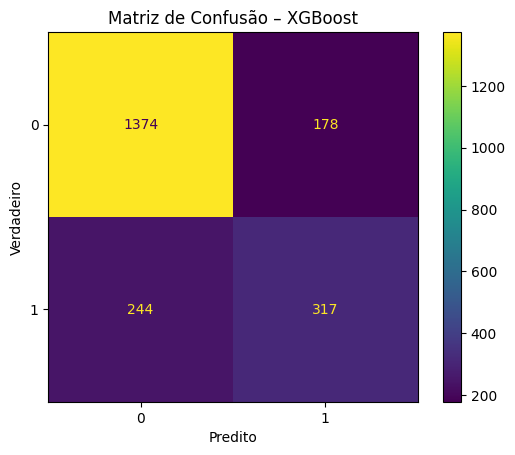

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# supondo que você já tenha:
# rf_test_preds, mlp_test_preds, xgb_test_preds
# y_test

# dicionário com rótulos e previsões
results = {
    "Random Forest": rf_test_preds,
    "MLP":           mlp_test_preds,
    "XGBoost":       xgb_test_preds
}

for name, preds in results.items():
    # calcula matriz de confusão
    cm = confusion_matrix(y_test, preds, labels=[0, 1])
    
    # plota
    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=ax)
    
    ax.set_title(f"Matriz de Confusão – {name}")
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.show()
